# nb-model_tcn-3

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath, exists
from pathlib import Path
from functools import partial
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_tcn.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from verification.batch_norm import BatchNormVerificationCallback
from verification.batch_gradient import BatchGradientVerificationCallback
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from pytorch_lightning import loggers as pl_loggers

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, str_now, is_valid, isnt, makedir_if_not_exists, load_df, load_json, dump_json, rectify_json
from model.common import ASSETS, INTERVAL_YEARS, OPTUNA_DB_FNAME, OPTUNA_N_TRIALS, OPTUNA_TIMEOUT_HOURS, INTRADAY_LEN
from model.common import PYTORCH_ACT1D_LIST, PYTORCH_INIT_LIST
from model.pl_xgdm import XGDataModule
from recon.viz import *
# from model.pl_np import ANP
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

# %autoreload 1
# %aimport model.np_util, model.pl_np, model.pl_generic, model.metrics_util, model.model_util

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_tcn.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


## tune over chosen data

In [2]:
max_epochs = None
min_epochs = 20
model_name = 'stcn'
asset_name = ASSETS[0]
fdata_name = 'h_pba_mzo,h_vol_mzo'
ldata_name = 'ddir'
monitor = 'val_accuracy'
num_classes = 2

optimize_dir = {
    'val_loss': 'minimize'
}.get(monitor, 'maximize')

# model options: stcn, anp
if (model_name in ('stcn', 'StackedTCN', 'GenericModel_StackedTCN')):
    from model.pl_generic import GenericModel
    from model.model_util import StackedTCN
    pl_model_fn, pt_model_fn = GenericModel, StackedTCN
elif (model_name in ('anp', 'AttentiveNP', 'NPModel_AttentiveNP')):
    from model.pl_np import NPModel
    from model.np_util import AttentiveNP
    pl_model_fn, pt_model_fn = NPModel, AttentiveNP
elif (model_name in ('ffn', 'FFN', 'GenericModel_FNN')):
    from model.pl_generic import GenericModel
    from model.model_util import FFN
    pl_model_fn, pt_model_fn = GenericModel, FFN
model_name = f'{pl_model_fn.__name__}_{pt_model_fn.__name__}'

m_params = pt_model_fn.suggest_params(trial=None, num_classes=num_classes, add_ob=True)
t_params = pl_model_fn.suggest_params(trial=None, num_classes=num_classes)
logging.getLogger("lightning").setLevel(logging.ERROR)
print('cuda status: {}'.format('✓' if (torch.cuda.is_available()) else '🞩'))

cuda status: 🞩


/home/kev/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
PYTORCH_INIT_LIST

('zeros',
 'ones',
 'normal',
 'orthogonal',
 'xavier_uniform',
 'xavier_normal',
 'kaiming_uniform',
 'kaiming_normal')

In [4]:
PYTORCH_ACT1D_LIST

('lrelu',
 'celu',
 'prelu',
 'selu',
 'relu',
 'elu',
 'gelu',
 'sig',
 'tanh',
 'splus',
 'smax',
 'logsmax')

In [5]:
m_params

{'size': 128,
 'depth': 3,
 'kernel_sizes': 8,
 'input_dropout': 0.0,
 'output_dropout': 0.0,
 'global_dropout': 0.5,
 'global_dilation': True,
 'block_act': 'elu',
 'out_act': 'relu',
 'block_init': 'xavier_uniform',
 'out_init': 'xavier_uniform',
 'pad_mode': 'full',
 'downsample_type': 'conv2d',
 'label_size': 1,
 'ob_out_shapes': 2,
 'ob_params': None}

## 龍 tune model params

In [6]:
m_params['size'] = 5
m_params['depth'] = 2
m_params['kernel_sizes'] = 8 * 3 + 1

m_params['global_dropout'] = 0
m_params['input_dropout'] = 0.1
m_params['output_dropout'] = 0

m_params['block_act'] ='relu'
m_params['block_init'] = 'kaiming_uniform'

m_params['out_act'] = 'relu'
m_params['out_init'] = 'kaiming_uniform'

m_params['ob_act'] = 'relu'
m_params['ob_init'] = 'kaiming_uniform'
m_params['ob_out_shapes'] = [2]

m_params['pad_mode'] = 'full'

## 龍 tune train params

In [7]:
class_weights = torch.zeros(num_classes, dtype=torch.float32, device='cpu', requires_grad=False)
class_weights[0] = .52
class_weights[1] = 1-class_weights[0]

opt = {
    'name': 'adam',
    'kwargs': {
        'lr': 1e-3,
        'betas': (0.9, 0.999),
        'weight_decay': 0,
        'amsgrad': False
    }
}

t_params['loss'] = 'ce'
t_params['class_weights'] = None #class_weights
t_params['train_shuffle'] = True
t_params['batch_size'] = 256
t_params['epochs'] = 200
t_params['opt'] = opt
t_params['window_size'] = 10

## data, loggers, model

In [8]:
fret=None
dm = XGDataModule(t_params, asset_name, fdata_name, ldata_name, fret=fret)
dm.prepare_data()
dm.setup()

# trial_time = str_now().replace(' ', '_').replace(':', '-')
# study_dir = MODEL_DIR +sep.join(['log', model_name, asset_name, dm.name]) +sep
# makedir_if_not_exists(study_dir)
# trial_dir = f'{study_dir}{trial_time}{sep}'
# bench_fname = 'benchmark.json'
# if (not exists('{study_dir}{bench_fname}')):
#     bench = dm.get_benchmarks()
#     dump_json(bench, bench_fname, study_dir)
# print('trial dir:', trial_dir)

# csv_log = pl.loggers.csv_logs.CSVLogger(trial_dir, name='', version='')
# tb_log = pl.loggers.tensorboard.TensorBoardLogger(trial_dir, name='', version='', log_graph=False)
# chk_callback = pl.callbacks.ModelCheckpoint(f'{trial_dir}chk{sep}', monitor=monitor, mode=optimize_dir[:3])
# ver_callbacks = (BatchNormVerificationCallback(), BatchGradientVerificationCallback())

mdl = pl_model_fn(pt_model_fn, m_params, t_params, dm.fobs)

/home/kev/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SimulatedReturn). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [11]:
print(dm.data[0].index.levels[1])
print(dm.data[0].index.levels[2])

Index(['00_pba_hdmx', '01_pba_hdzn', '02_pba_hdod', '10_vol_hdmx',
       '11_vol_hdzn', '12_vol_hdod'],
      dtype='object', name='id1')
Index(['0_open', '1_high', '2_low', '3_close', '4_avgPrice'], dtype='object', name='id2')


In [12]:
dm.fobs

(6, 5, 80)

In [13]:
dm.train[0].shape

(1761, 6, 5, 8)

In [9]:
mdl

GenericModel(
  (model): OutputBlock(
    (emb): StackedTCN(
      (model): Sequential(
        (rb[conv2d]_0): ResidualBlock(
          (net): Sequential(
            (tl[(6, 5, 80)->(5, 1, 104)]_0_0): TemporalLayer2d(
              (layer): Sequential(
                (0): ZeroPad2d((24, 24, 0, 0))
                (1): Conv2d(6, 5, kernel_size=(5, 25), stride=(1, 1))
                (2): ReLU()
                (3): Dropout2d(p=0.1, inplace=False)
              )
            )
            (tl[(5, 1, 104)->(5, 1, 128)]_0_1): TemporalLayer2d(
              (layer): Sequential(
                (0): ZeroPad2d((24, 24, 0, 0))
                (1): Conv2d(5, 5, kernel_size=(1, 25), stride=(1, 1))
                (2): ReLU()
                (3): Dropout2d(p=0.1, inplace=False)
              )
            )
          )
          (out_act): ReLU()
          (padding): ZeroPad2d((24, 24, 0, 0))
          (downsample): Conv2d(6, 5, kernel_size=(5, 1), stride=(1, 1))
        )
        (rb[conv2d]_

In [15]:
#mdl.model.emb.model

In [16]:
#mdl.model.emb.model[0].net[0].layer[1].weight.shape

In [17]:
s = lambda v: "{0:.3f}".format(v)
def print_bench(bench, split):
    print(f'{split}')
    print('1:', s(bench[f'{split}_label_dist'][1]*100) +'%')
    print('0:', s(bench[f'{split}_label_dist'][0]*100) +'%')
    print()
    print('ret', '   ', 'sharpe')
    print(s(bench[f'{split}_bs']), ' ', s(bench[f'{split}_bs_sharpe']))
    print(s(bench[f'{split}_os']), ' ', s(bench[f'{split}_os_sharpe']))
    print()

print_bench(bench, 'train')
print_bench(bench, 'val')

train
1: 54.742%
0: 45.258%

ret     sharpe
0.503   0.020
15.943   0.847

val
1: 51.889%
0: 48.111%

ret     sharpe
0.066   0.016
2.950   1.063



## run

In [18]:
makedir_if_not_exists(trial_dir)
dump_json(rectify_json(m_params), 'params_m.json', trial_dir)
dump_json(rectify_json(t_params), 'params_t.json', trial_dir)

trainer = pl.Trainer(max_epochs=max_epochs or t_params['epochs'],
        min_epochs=min_epochs, logger=[csv_log, tb_log],
        callbacks=[chk_callback, *ver_callbacks],
        limit_val_batches=1.0, gradient_clip_val=0., #track_grad_norm=2,
        auto_lr_find=False, amp_level='O1', precision=16,
        default_root_dir=trial_dir, weights_summary=None,
        #overfit_batches=1,
        gpus=-1 if (torch.cuda.is_available()) else None)
trainer.fit(mdl, datamodule=dm)

/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Experiment logs directory /home/kev/crunch/model/log/GenericModel_StackedTCN/sp_500/2007_2018_ddir_h_pba_mzo_h_vol_mzo/2020-12-16_19-42-12/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your model is mixing data across the batch dimension. This can lead to wrong gradient updates in the optimizer. Check the operations that reshape and permute tensor dimensions in your model.
  warnings.warn(*args, **kwargs)


1

In [19]:
bench_res = load_json('benchmark.json', study_dir)
raw_res = load_df('metrics.csv', trial_dir, data_format='csv')

In [20]:
split = 'val'
val_cols = [f'{split}_loss', f'{split}_f1.0', f'{split}_accuracy',
            f'{split}_br', f'{split}_br_sharpe', f'{split}_br_min']
res = {
    'val': raw_res[sorted(val_cols)].dropna(how='any'),
    #'train': raw_res[train_col].dropna(how='any'),
}

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

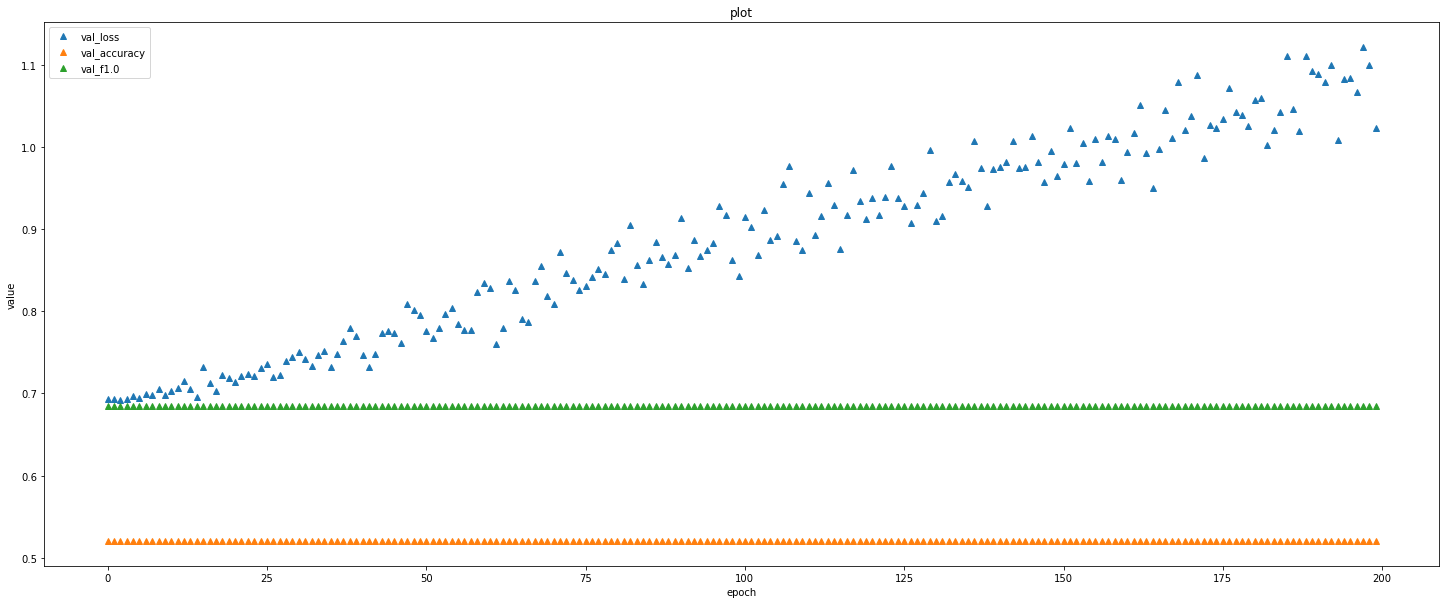

In [21]:
split = 'val'
plot_df(res[split][[f'{split}_loss', f'{split}_accuracy', f'{split}_f1.0']], xlabel='epoch', ylabel='value')

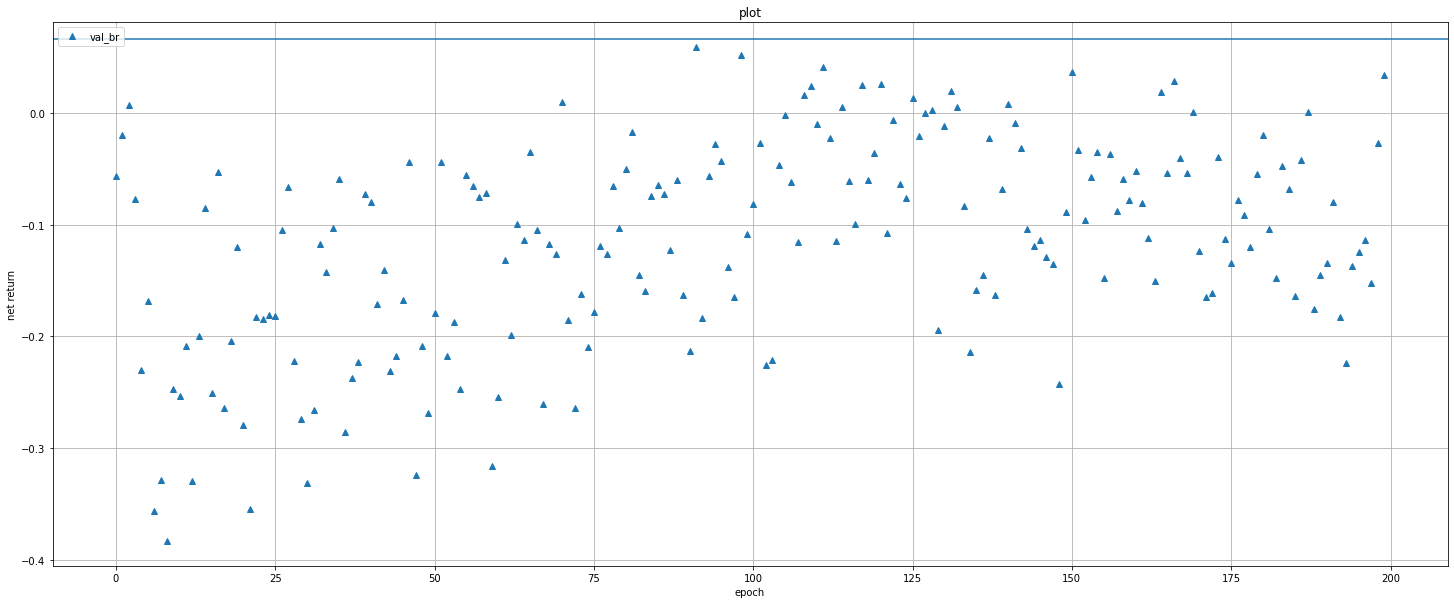

In [22]:
split = 'val'
p = plot_df(res[split][[f'{split}_br']], xlabel='epoch', ylabel='net return')
p.axhline(y=bench_res[f'{split}_bs'])
#p.axhline(y=bench_res[f'{split}_os'])
p.grid()
p.show()

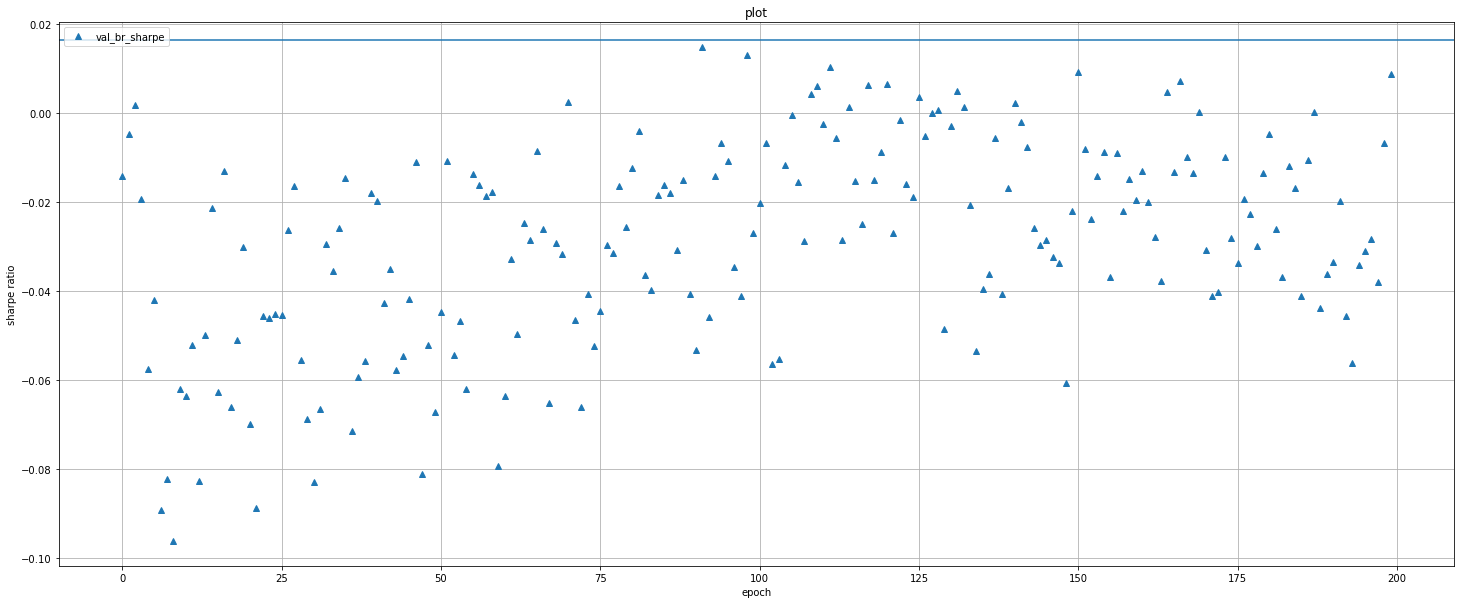

In [23]:
split = 'val'
p = plot_df(res[split][[f'{split}_br_sharpe']], xlabel='epoch', ylabel='sharpe ratio')
p.axhline(y=bench_res[f'{split}_bs_sharpe'])
#p.axhline(y=bench_res[f'{split}_os_sharpe'])
p.grid()
p.show()